In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

outputs_dir = "gcn/toy2/outputs/logs"

# debugging_file = "/data/brain_/gcn/toy/outputs/logs/baseline_ic5_lr0.001/data_n10000_seed8_hxd0.01_hn0.05_xn0.05.log.txt"
# example_string = "[val 20/100: 0.06350064277648926s] loss=1.8832584941197956 acc=0.2986111111111111"

def subfolder2mticlrseed(subfoldername):
    splt = subfoldername.split("_")
    model_type = splt[0]
    ic = int(splt[1][2:])
    lr = float(splt[2][2:]) if len(splt) > 2 else -1
    rseed = int(splt[3][4:])
    return model_type, ic, lr, rseed

def logfilename2params(filename):
    # filename = data_nXYZ_seedXYZ_hxd0.01_hn0.05_xn0.05.log.txt
    splt = filename.replace(".log.txt", "").split("_")  # split(".")[0].split("_")
    try:
        n = int(splt[1][1:])
        seed = int(splt[2][4:])
        hxd = float(splt[3][3:])
        hn = float(splt[4][2:])
        xn = float(splt[5][2:])
        return n, seed, hxd, hn, xn
    except:
        print(splt)
        raise
        return -1, -1, -1, -1, -1
    
print("{} data files".format(len(os.listdir("/data/gcn_toy2/"))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
12 data files


In [3]:
def parse_line(line):
    line = line[1:]  # All lines start with "["
    timestamp, values = line.split("]")

    prefix_epoch_time = timestamp.split(" ")
    if len(prefix_epoch_time) <= 2:
        if "/" in prefix_epoch_time[0]:
            prefix = "train"
            epoch_time = prefix_epoch_time
        else:
            prefix = prefix_epoch_time[0][:- 1]
            epoch_time = ["{}/{}:".format(-1, -1), "{}".format(prefix_epoch_time[1])]
    else:
        prefix = prefix_epoch_time[0]
        epoch_time = prefix_epoch_time[1:]
    e, me = epoch_time[0].lstrip(" ").rstrip(" ").split("/")
    me = me[:len(me) - 1]
    t = epoch_time[1][:len(epoch_time[1]) - 1]
    lossstr, accstr = values.lstrip(" ").rstrip(" ").split(" ")
    loss = lossstr.split("=")[1]
    acc = accstr.split("=")[1]
    return prefix, int(e), int(me), float(t), float(loss), float(acc)

def parse_log(filename):
    values = defaultdict(lambda: defaultdict(lambda: []))
    with open(filename, "r") as f:
        for line in f:
            line = line.rstrip("\r\n ")
            if len(line) == 0 or line[0] != "[":
                continue
#             print("Parsing: {}".format(line))
            prefix, e, me, t, l, a = parse_line(line)
            values[prefix]["max epoch"] = me
            values[prefix]["epoch"].append(e)
            values[prefix]["time"].append(t)
            values[prefix]["loss"].append(l)
            values[prefix]["acc"].append(a)
    for prefix in values.keys():
        values[prefix]["epoch"] = np.array(values[prefix]["epoch"]).astype(np.float32)
        values[prefix]["time"] = np.array(values[prefix]["time"]).astype(np.float32)
        values[prefix]["loss"] = np.array(values[prefix]["loss"]).astype(np.float32)
        values[prefix]["acc"] = np.array(values[prefix]["acc"]).astype(np.float32)
    return values

In [32]:
# density -> noise-tuple -> mt -> ic -> lr -> list
log_files_dict = defaultdict(  # density
    lambda: defaultdict(  # noise
        lambda: defaultdict( # dataset seed
            lambda: defaultdict( # mt
                lambda: defaultdict( # ic
                    lambda: defaultdict( # lr
                        lambda: [],
                    )
                )
            )
        )
    )
)

count = 0
for subfolder in os.listdir(outputs_dir):
    mt, ic, lr, rseed = subfolder2mticlrseed(subfolder)
    
    if lr < 0:
        continue
    for logfile in os.listdir(os.path.join(outputs_dir, subfolder)):
        fullpath = os.path.join(outputs_dir, subfolder, logfile)
        n, dseed, hxd, hn, xn = logfilename2params(logfile)
        log_files_dict[hxd][(hn, xn)][dseed][mt][ic][lr].append(fullpath)
        if count == 0:
            print(fullpath)
        count += 1

print("Found {} logfiles".format(count))
nt = (hn, xn)
all_hxds = list(log_files_dict.keys())
all_nts = list(log_files_dict[hxd].keys())
all_dseeds = list(log_files_dict[hxd][nt].keys())
all_mts = list(log_files_dict[hxd][nt][dseed].keys())
all_ics = list(log_files_dict[hxd][nt][dseed][mt].keys())
all_lrs = list(log_files_dict[hxd][nt][dseed][mt][ic].keys())

gcn/toy2/outputs/logs/fgl_ic32_lr0.10000000_seed860/data_n10000_seed666_hxd0.05_hn0.05_yn0.05.log.txt
Found 768 logfiles


In [12]:
values_dict = copy.deepcopy(log_files_dict)  # Averages over multiple runs on each dataset seed
for density in all_hxds:
    for nt in all_nts:
        for dseed in all_dseeds:
            for mt in all_mts:
                for ic in all_ics:
                    for lr in all_lrs:
                        summed_values = None
                        logfiles = values_dict[density][nt][dseed][mt][ic][lr]
                        if len(logfiles) == 0:
                            continue
                        for logfile in logfiles:
                            values = parse_log(logfile)
                            if summed_values is None:
                                summed_values = values
                            else:
                                for prefix in values.keys():
                                    summed_values[prefix]["epoch"] += values[prefix]["epoch"]
                                    summed_values[prefix]["time"] += values[prefix]["time"]
                                    summed_values[prefix]["loss"] += values[prefix]["loss"]
                                    summed_values[prefix]["acc"] += values[prefix]["acc"]
                        for prefix in summed_values.keys():
                            summed_values[prefix]["epoch"] /= len(logfiles)
                            summed_values[prefix]["time"] /= len(logfiles)
                            summed_values[prefix]["loss"] /= len(logfiles)
                            summed_values[prefix]["acc"] /= len(logfiles)
                        values_dict[density][nt][dseed][mt][ic][lr] = summed_values

In [33]:
print(all_hxds)
print(all_nts)
print(all_dseeds)
print(all_mts)
print(all_ics)
print(all_lrs)

[0.05, 0.2, 0.01, 0.5]
[(0.05, 0.05)]
[1337, 666, 42]
['baseline', 'fgl']
[32, 16, 4, 1]
[0.1, 0.001]


In [27]:
def model_acc(mt, hxd, ic, lr):
    return [(values_dict[hxd][(0.05, 0.05)][dseed][mt][ic][lr]["val"]["acc"][-1]) for dseed in all_dseeds]
def acc_diff(hxd, ic, lr):
    return [x - y for (x, y) in zip(model_acc("fgl", hxd, ic, lr), model_acc("baseline", hxd, ic, lr))]
#     return [np.max(values_dict[hxd][(0.05, 0.05)][dseed]['fgl'][ic][lr]["val"]["acc"]) - np.max(values_dict[hxd][(0.05, 0.05)][dseed]['baseline'][ic][lr]["val"]["acc"]) for dseed in all_dseeds]
    #     return [values_dict[hxd][(0.05, 0.05)][dseed]['fgl'][ic][lr]["test"]["acc"][0] - values_dict[hxd][(0.05, 0.05)][dseed]['baseline'][ic][lr]["test"]["acc"][0] for dseed in all_dseeds]
for hxd in all_hxds:
    for ic in all_ics:
        for lr in [0.001]:
            print("hxd={} ic={} lr={}, max-val-acc-difference={}".format(hxd, ic, lr, acc_diff(hxd, ic, lr)))

hxd=0.05 ic=32 lr=0.001, max-val-acc-difference=[0.039310545, 0.09213787, 0.036334336]
hxd=0.05 ic=16 lr=0.001, max-val-acc-difference=[0.03807041, 0.031126022, 0.021577388]
hxd=0.05 ic=4 lr=0.001, max-val-acc-difference=[-0.008184493, 0.034970224, 0.009424627]
hxd=0.05 ic=1 lr=0.001, max-val-acc-difference=[0.022073388, 0.017237067, -0.0078125]
hxd=0.2 ic=32 lr=0.001, max-val-acc-difference=[0.08196926, 0.18799606, 0.16666663]
hxd=0.2 ic=16 lr=0.001, max-val-acc-difference=[0.14918154, 0.15252978, 0.120411694]
hxd=0.2 ic=4 lr=0.001, max-val-acc-difference=[0.02244541, 0.15265372, 0.17199898]
hxd=0.2 ic=1 lr=0.001, max-val-acc-difference=[0.12524804, 0.16989091, 0.038938493]
hxd=0.01 ic=32 lr=0.001, max-val-acc-difference=[0.20300102, 0.18439978, 0.19568458]
hxd=0.01 ic=16 lr=0.001, max-val-acc-difference=[0.16021824, 0.17968756, 0.19382438]
hxd=0.01 ic=4 lr=0.001, max-val-acc-difference=[0.15054566, 0.14645338, 0.16951889]
hxd=0.01 ic=1 lr=0.001, max-val-acc-difference=[0.17373514, 0.

In [38]:
def prefix_metric(mt, hxd, ic, lr, dseed, prefix="val", metric="acc"):
    return (values_dict[hxd][(0.05, 0.05)][dseed][mt][ic][lr][prefix][metric])
for dseed in all_dseeds:
    print("dseed={}".format(dseed))
    print(prefix_metric("fgl", 0.01, 1, 0.001, dseed))
    print(prefix_metric("baseline", 0.01, 32, 0.001, dseed))

dseed=1337
[0.14880952 0.44109622 0.5141369  0.5376984  0.5484871  0.55691963
 0.5662203  0.57080853 0.57254463 0.5749008 ]
[0.2547123  0.31956846 0.3426339  0.34176588 0.3545387  0.3544147
 0.34747022 0.35404265 0.35267857 0.3500744 ]
dseed=666
[0.13417658 0.4310516  0.5052083  0.5296379  0.54228675 0.5483631
 0.55580354 0.5554316  0.56063986 0.56312007]
[0.2545883  0.3377976  0.33978176 0.3529266  0.35515875 0.35726684
 0.35540673 0.36297125 0.3612351  0.36346728]
dseed=42
[0.16480654 0.4594494  0.5203373  0.53596234 0.5498512  0.5549355
 0.55679566 0.5611359  0.56498015 0.5648562 ]
[0.26822916 0.32775298 0.34275794 0.34424603 0.35677084 0.35639882
 0.35280257 0.35032243 0.35267857 0.3534226 ]


In [155]:
hxds = values_dict.keys()
print("Found densities : {}".format(hxds))
ics = values_dict[0.01][(0.05, 0.05)]['fgl'].keys()
print("Found intermediate channel counts : {}".format(ics))
lrs = values_dict[hxd][(0.05, 0.05)]['fgl'][ic].keys()
print("Found learning rates : {}".format(lrs))
# for density in values_dict.keys():
#     for nt in values_dict[density].keys():
#             for ic in values_dict[density][nt]['fgl'].keys():
#                 for lr in values_dict[density][nt]['fgl'][ic].keys():
                    

Found densities : dict_keys([0.2, 0.04, 0.5, 0.02, 0.01, 0.1])
Found intermediate channel counts : dict_keys([128, 1, 10, 3, 5])
Found learning rates : dict_keys([1e-05, 0.1, 0.001, 0.0001])


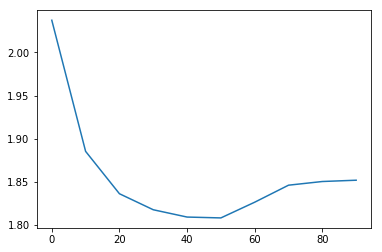

In [191]:
# Training loss
# As we change ic
mt = 'baseline'
lr = 0.0001
ic = 3
hdx = 0.5
plt.plot(values_dict[hxd][(0.05, 0.05)][mt][ic][lr]["val"]['epoch'], values_dict[hxd][(0.05, 0.05)][mt][ic][lr]["val"]['loss'], label='')